In [ ]:
%%bash
pip install -qq fsspec
pip install -qq gcsfs
pip -q install kaggle

In [ ]:
from google.colab import drive

drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
%%bash
mkdir ~/.kaggle
cp ../gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
username = "tarunbisht11"
dataset_name = "intruder-detection"
competition_data = ""
save_path = "./dataset"

In [ ]:
import kaggle

kaggle.api.authenticate()

In [ ]:
#!kaggle competitions download {competition_data}
!kaggle datasets download {username}/{dataset_name}
!mkdir {save_path}
!unzip -q {dataset_name}.zip -d {save_path}
!rm {dataset_name}.zip

100% 8.43G/8.43G [03:09<00:00, 43.7MB/s]
100% 8.43G/8.43G [03:09<00:00, 47.7MB/s]


In [ ]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir("..")
elif not pathlib.Path("models").exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3219, done.
remote: Counting objects: 100% (3219/3219), done.
remote: Compressing objects: 100% (2730/2730), done.
remote: Total 3219 (delta 863), reused 1354 (delta 445), pack-reused 0
Receiving objects: 100% (3219/3219), 33.42 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (863/863), done.


In [ ]:
%%bash
# Install the Object Detection API
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -qq .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
class Config:
    batch_size = 32
    # image width and height (width, height)
    image_size = (320, 320)
    model_name = "ssd_mobilenet_fpnlite"
    epochs = 100
    lr = 0.01
    finetune = True
    # for early_stopping
    patience = 5
    train_images_dir = "./dataset/surveillance-dataset/images/train"
    val_images_dir = "./dataset/surveillance-dataset/images/test"
    labelstxt_path = "./dataset/surveillance-dataset/labels.txt"

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import time
import cv2
import random
import io
import math
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import albumentations as A

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline
plt.rcParams["axes.grid"] = False
plt.rcParams["xtick.labelsize"] = False
plt.rcParams["ytick.labelsize"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["figure.figsize"] = [14, 7]

print(tf.__version__)

2.7.0


In [ ]:
def load_image(path: str, size: tuple = None) -> np.array:
    """load an image from path specified and resize it to size specified

    Args:
        path (str): local path to image
        size (tuple, optional): width and height of image as tuple. Defaults to None.

    Returns:
        np.array: image as numpy array
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if size:
        image = cv2.resize(image, size)
    return image.astype(np.uint8)

In [ ]:
def draw_boxes(
    image: np.array,
    boxes: np.array,
    classes: np.array,
    scores: np.array,
    category_index: dict,
    height: int,
    width: int,
    min_threshold: float = 0.5,
    put_label: bool = True,
) -> np.array:
    """Draw bounding box in images

    Args:
        image (np.array): image to draw rectangle on
        boxes (np.array): boxes to draw all elements are in range 0 and 1
        classes (np.array): class of each bounding box
        scores (np.array): probability score of each bounding box
        category_index (dict): dictionary representation of labels with id and class names
        height (int): height of image to scale bounding boxes with respect to image
        width (int): widht of image to scale bounding boxes with respect to image
        min_threshold (float, optional): min threshold above which to consider the bounding box. Defaults to 0.5.
        put_label (bool, optional): put class and score label at top of each bounding box. Defaults to True.

    Returns:
        np.array: image as numpy array with boxes drawn
    """
    for i in range(len(scores)):
        if (scores[i] > min_threshold) and (scores[i] <= 1.0):
            y_min = int(max(0, (boxes[i][0] * height)))
            x_min = int(max(0, (boxes[i][1] * width)))
            y_max = int(min(height, (boxes[i][2] * height)))
            x_max = int(min(width, (boxes[i][3] * width)))

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (10, 255, 0), 2)
            if put_label:
                if classes[i] in category_index:
                    class_name = category_index[classes[i]]["name"]
                else:
                    class_name = "N/A"
                label = f"{class_name}: {int(scores[i] * 100)}%"
                labelSize, baseLine = cv2.getTextSize(
                    label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2
                )
                label_min_y = max(y_min, labelSize[1] + 10)
                cv2.rectangle(
                    image,
                    (x_min, label_min_y - labelSize[1] - 10),
                    (x_min + labelSize[0], label_min_y + baseLine - 10),
                    (255, 255, 255),
                    cv2.FILLED,
                )
                cv2.putText(
                    image,
                    label,
                    (x_min, label_min_y - 7),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 0, 0),
                    2,
                )
    return image

In [ ]:
def plot_detections(
    image_np, boxes, classes, scores, category_index, height, width, image_name=None
):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    draw_boxes(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        height,
        width,
        min_threshold=0.8,
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [ ]:
labelstxt_path = "/content/dataset/surveillance-dataset/labels.txt"
train_images_dir = "/content/dataset/surveillance-dataset/images/train"
test_images_dir = "/content/dataset/surveillance-dataset/images/test"
train_csv_path = "/content/dataset/surveillance-dataset/train.csv"
test_csv_path = "/content/dataset/surveillance-dataset/test.csv"

In [ ]:
train_csv = pd.read_csv(train_csv_path)
train_csv.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,baf7d41fcd21b89e.jpg,1024,768,person,232,454,332,700
1,d99cf36f31fc43ac.jpg,1024,680,person,0,0,936,679
2,c35e7d9b939ac69a.jpg,1024,680,cat,12,58,1023,615
3,a6712371fba3d9cc.jpg,1024,685,monkey,92,22,966,685
4,c97f126b37b55ad5.jpg,1024,680,person,4,56,634,631
5,c97f126b37b55ad5.jpg,1024,680,person,587,76,941,606


In [ ]:
test_csv = pd.read_csv(test_csv_path)
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,061331ad6774a187.jpg,680,1024,person,47,136,680,1024
1,d5a19e615dc779ef.jpg,1024,691,cat,115,0,995,691
2,803274329a41469d.jpg,1024,768,cat,302,0,1008,768
3,3ea0739106e065a6.jpg,1024,768,person,57,474,156,768
4,c273bc7802f44cdc.jpg,1024,768,dog,15,0,1024,768


In [ ]:
def preprocess_image(image: np.array) -> np.array:
    """preprocess image function

    Args:
        image (np.array): image as numpy array

    Returns:
        np.array: preprocessed image as numpy array
    """
    image = image.astype(np.float32)
    if image.shape[2] == 3:
        channel_means = [123.68, 116.779, 103.939]
        return (image - [[channel_means]]).astype(np.float32)
    else:
        return image.astype(np.float32)


def deprocess_image(preprocessed_image: np.array) -> np.array:
    """deprocess image function

    Args:
        preprocessed_image (np.array): preprocessed image as numpy array

    Returns:
        np.array: deprocessed image as numpy array
    """
    if preprocessed_image.shape[2] == 3:
        channel_means = [123.68, 116.779, 103.939]
        return (preprocessed_image + [[channel_means]]).astype(np.uint8)
    else:
        return preprocessed_image.astype(np.uint8)

In [ ]:
class ImageAugmentations:
    """
    image_size: resize image to -> (width, height)
    train_augs: include augmentations like random crop, rotation etc training if false then return
                only resize image as pytorch tensor
    """

    def __init__(
        self, image_size=None, apply_augs=False, normalize=False, bbox_format=None
    ):
        self.image_size = image_size
        self.apply_augs = apply_augs
        self.normalize = normalize
        self.bbox_format = bbox_format

    def train_augs(self):
        augs = []
        if self.image_size is not None:
            augs.append(A.Resize(self.image_size, self.image_size))
        if self.normalize:
            # imagenet normalization
            augs.append(
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                )
            )
        if self.apply_augs:
            img_augs = [
                A.HorizontalFlip(p=0.5),
                A.ChannelShuffle(p=0.1),
                A.OneOf(
                    [
                        A.HueSaturationValue(
                            hue_shift_limit=0.2,
                            sat_shift_limit=0.2,
                            val_shift_limit=0.2,
                            p=0.5,
                        ),
                        A.RandomBrightnessContrast(
                            brightness_limit=0.2, contrast_limit=0.2, p=0.5
                        ),
                    ],
                    p=0.5,
                ),
                A.ToGray(p=0.01),
                A.RandomGamma(p=0.1),
                A.Sharpen(p=0.1),
                A.Cutout(
                    num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.2
                ),
            ]
            augs = augs + img_augs
        if self.bbox_format is not None:
            return A.Compose(
                augs,
                bbox_params=A.BboxParams(
                    format=self.bbox_format,
                    min_area=0,
                    min_visibility=0,
                    label_fields=["labels"],
                ),
            )
        return A.Compose(augs)

    def valid_augs(self):
        augs = []
        if self.image_size is not None:
            augs.append(A.Resize(self.image_size, self.image_size))
        if self.normalize:
            # imagenet normalization
            augs.append(
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                )
            )
        if self.bbox_format is not None:
            return A.Compose(
                augs,
                bbox_params=A.BboxParams(
                    format=self.bbox_format,
                    min_area=0,
                    min_visibility=0,
                    label_fields=["labels"],
                ),
            )
        return A.Compose(augs)

In [ ]:
class DetectionDataset(tf.keras.utils.Sequence):
    def __init__(
        self,
        df,
        image_dir_path,
        labeltxt_path,
        batch_size,
        image_size=None,
        augmentations=None,
        img_preprocess_fn=None,
    ):
        super().__init__()
        self.df = df
        self.filenames = df["filename"].unique()
        self.image_dir_path = image_dir_path
        self.label_mapper, self.category_index = self.read_label_file(labeltxt_path)
        self.num_classes = (
            len(self.label_mapper) - 1
        )  # -1 for removing background class
        self.length = self.df.filename.nunique()
        self.batch_size = batch_size
        self.augs = augmentations
        self.image_size = image_size
        self.preprocess_fn = img_preprocess_fn

    def __len__(self):
        return self.length // self.batch_size

    def get_category_index(self):
        return self.category_index

    def get_label_mapper(self):
        return self.label_mapper

    def read_label_file(self, labeltxt_path):
        with open(labeltxt_path, "r") as label_file:
            lines = label_file.readlines()
            labels_to_index = {}
            index_to_label = {}
            for row, content in enumerate(lines):
                index_to_label[row] = {"id": row, "name": content.strip()}
                labels_to_index[content.strip()] = {"id": row, "name": content.strip()}
        return labels_to_index, index_to_label

    def __getitem__(self, idx):
        start_ = idx * self.batch_size
        end_ = (idx + 1) * self.batch_size
        return self.__get_samples(self.filenames[start_:end_])

    def __get_samples(self, filenames):
        images = []
        boxes = []
        onehots = []
        for filename in filenames:
            sample = self.df[self.df["filename"] == filename]
            file_path = os.path.join(self.image_dir_path, filename)
            image = load_image(file_path, size=self.image_size)
            # width and height
            width = sample.iloc[0, 1]
            height = sample.iloc[0, 2]
            # box coordinates
            xmin = sample.iloc[:, 4].values
            ymin = sample.iloc[:, 5].values
            xmax = sample.iloc[:, 6].values
            ymax = sample.iloc[:, 7].values
            # preparing boxes
            bboxes = np.transpose([xmin, ymin, xmax, ymax])
            # get text labels
            label_txt = sample.iloc[:, 3].values
            if self.augs is not None:
                for i in range(10):
                    transform = self.augs(image=image, bboxes=bboxes, labels=label_txt)
                    if len(transform["bboxes"]) > 0:
                        image = transform["image"]
                        bboxes = transform["bboxes"]
                        label_txt = transform["labels"]
                        break
            # one hot encoding labels
            label_id = [self.label_mapper[label]["id"] - 1 for label in label_txt]
            onehot = tf.one_hot(label_id, self.num_classes)
            # swapping boxes
            trans_bboxes = []
            for xmin, ymin, xmax, ymax in bboxes:
                trans_bboxes.append(
                    [ymin / height, xmin / width, ymax / height, xmax / width]
                )

            bboxes = tf.convert_to_tensor(trans_bboxes, dtype=tf.float32)
            # image tensor
            if self.preprocess_fn is not None:
                image = self.preprocess_fn(image)
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            images.append(image)
            boxes.append(bboxes)
            onehots.append(onehot)
        return images, boxes, onehots

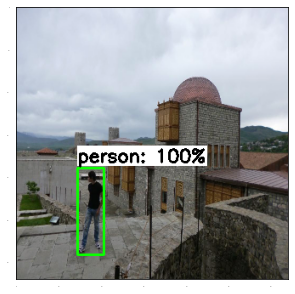

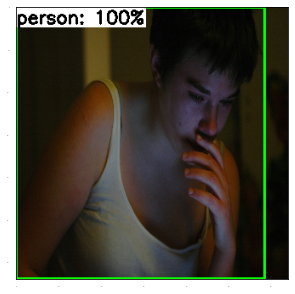

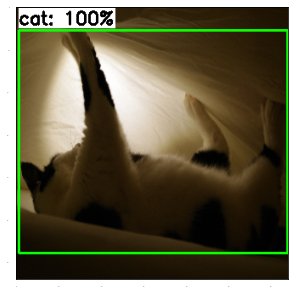

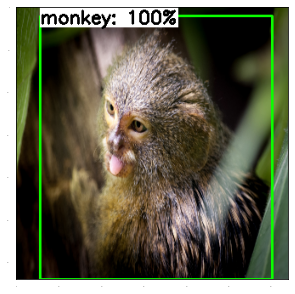

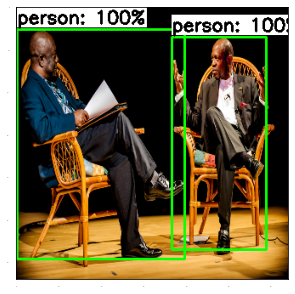

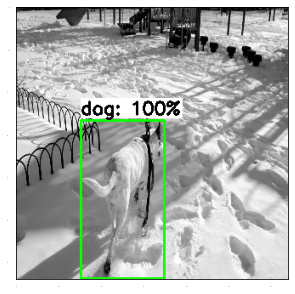

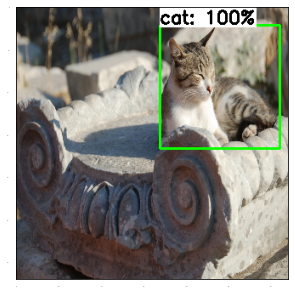

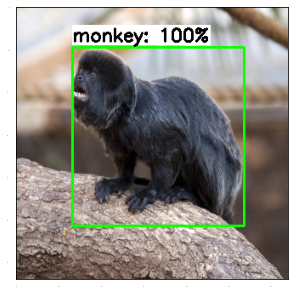

In [ ]:
ds = DetectionDataset(
    train_csv,
    image_dir_path=train_images_dir,
    labeltxt_path=labelstxt_path,
    batch_size=8,
    image_size=Config.image_size,
    img_preprocess_fn=preprocess_image,
)
num_classes = ds.num_classes
category_index = ds.get_category_index()
for imgs, boxes, labels in ds:
    for img, bbox, label in zip(imgs, boxes, labels):
        num_objs = len(bbox.numpy())
        dummy_scores = np.array(
            [1.0] * num_objs, dtype=np.float32
        )  # give boxes a score of 100%
        classes = (tf.argmax(label, axis=1) + 1).numpy()
        plt.figure(figsize=(10, 5))
        plot_detections(
            deprocess_image(img.numpy()),
            bbox.numpy(),
            classes,
            dummy_scores,
            category_index,
            height=Config.image_size[1],
            width=Config.image_size[0],
        )
        plt.show()
    break

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2021-12-26 10:59:05--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.2’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2021-12-26 10:59:05 (206 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.2’ saved [20515344/20515344]



In [ ]:
os.makedirs("logs", exist_ok=True)
OUTPUT_DIR = "logs/"


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()

In [ ]:
def create_detection_model(
    pipeline_config,
    num_classes,
    checkpoint_path=None,
    freeze_batchnorm=True,
    training=False,
    restore_classification_head=False,
):
    configs = config_util.get_configs_from_pipeline_file(pipeline_config)
    model_config = configs["model"]
    model_config.ssd.num_classes = num_classes
    model_config.ssd.freeze_batchnorm = freeze_batchnorm
    detection_model = model_builder.build(
        model_config=model_config, is_training=training
    )

    if checkpoint_path is not None:
        fake_model_predictor = tf.compat.v2.train.Checkpoint(
            _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
            _box_prediction_head=detection_model._box_predictor._box_prediction_head,
        )
        fake_model = tf.compat.v2.train.Checkpoint(
            _feature_extractor=detection_model._feature_extractor,
            _box_predictor=fake_model_predictor,
        )
        ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
        ckpt.restore(checkpoint_path).expect_partial()

    # Run model through a dummy image so that variables are created
    image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 768, 3]))
    prediction_dict = detection_model.predict(image, shapes)
    _ = detection_model.postprocess(prediction_dict, shapes)

    # save preprocessing steps here
    return detection_model

In [ ]:
def get_vars_to_finetune(detection_model):
    trainable_variables = detection_model.trainable_variables
    to_fine_tune = []
    # finetune box head and classification head ie.. train these layers only
    prefixes_to_train = [
        "WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead",
        "WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead",
    ]
    for var in trainable_variables:
        if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
            to_fine_tune.append(var)
    return to_fine_tune

In [ ]:
@tf.function
def train_step(train_ds, model, optimizer, vars_to_train, log_step=100):
    avg_loss = []
    step = 0
    for imgs, boxes, labels in train_ds:
        shapes = tf.constant(
            Config.batch_size * [Config.image_size[0], Config.image_size[1], 3],
            dtype=tf.int32,
        )
        model.provide_groundtruth(
            groundtruth_boxes_list=boxes, groundtruth_classes_list=labels
        )
        with tf.GradientTape() as tape:
            imgs = tf.convert_to_tensor(imgs)
            # get predictions
            prediction_dict = model.predict(imgs, shapes)
            # calculate loss
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = (
                losses_dict["Loss/localization_loss"]
                + losses_dict["Loss/classification_loss"]
            )
            # calculate gradients
            gradients = tape.gradient(total_loss, vars_to_train)
        optimizer.apply_gradients(zip(gradients, vars_to_train))
        avg_loss.append(total_loss)
        step += 1
        if step % log_step == 0:
            LOGGER.info(f"train_loss: {np.mean(avg_loss):.4f}")
        return np.mean(avg_loss)

In [ ]:
@tf.function
def val_step(val_ds, model):
    avg_loss = []
    for imgs, boxes, labels in val_ds:
        shapes = tf.constant(
            Config.batch_size * [Config.image_size[0], Config.image_size[1], 3],
            dtype=tf.int32,
        )
        model.provide_groundtruth(
            groundtruth_boxes_list=boxes, groundtruth_classes_list=labels
        )
        imgs = tf.convert_to_tensor(imgs)
        prediction_dict = model.predict(imgs, shapes)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = (
            losses_dict["Loss/localization_loss"]
            + losses_dict["Loss/classification_loss"]
        )
        avg_loss.append(total_loss)
    return np.mean(avg_loss)

In [ ]:
def train_loop(
    train_df,
    valid_df,
    model_pipeline_path,
    optimizer,
    model_checkpoint_path=None,
    log_step=100,
):
    tf.keras.backend.clear_session()
    # create dataset
    train_ds = DetectionDataset(
        train_df,
        image_dir_path=Config.train_images_dir,
        labeltxt_path=labelstxt_path,
        batch_size=Config.batch_size,
        image_size=Config.image_size,
        img_preprocess_fn=preprocess_image,
    )
    val_ds = DetectionDataset(
        valid_df,
        image_dir_path=Config.val_images_dir,
        labeltxt_path=labelstxt_path,
        batch_size=Config.batch_size,
        image_size=Config.image_size,
        img_preprocess_fn=preprocess_image,
    )
    num_classes = train_ds.num_classes
    category_index = train_ds.get_category_index()
    # create model
    model = create_detection_model(pipeline_config, num_classes, checkpoint_path)
    if Config.finetune:
        vars_to_train = get_vars_to_finetune(model)
    else:
        vars_to_train = model.trainable_variables
    # creating a checkpoint manager
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
    ckpt_manager = tf.train.CheckpointManager(
        checkpoint, f"{Config.model_name}_best_ckpt", max_to_keep=1
    )
    best_loss = np.inf
    patience_count = 0
    for epoch in range(Config.epochs):
        LOGGER.info(f"Epoch {epoch+1}")
        start_time = time.time()
        train_avg_loss = train_step(
            train_ds, model, optimizer, vars_to_train, log_step=log_step
        )
        val_avg_loss = val_step(val_ds, model)
        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - train_loss: {train_avg_loss:.4f}  val_loss: {val_avg_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Loss: {val_avg_loss:.4f}")
        if val_avg_loss < best_loss:
            best_loss = val_avg_loss
            ckpt_manager.save()
            LOGGER.info(f"Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model")
            patience_count = 0
        else:
            patience_count += 1
        if patience_count > Config.patience:
            break

In [ ]:
pipeline_config = "./ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config"
checkpoint_path = "./ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"
optimizer = tf.keras.optimizers.Adam(learning_rate=Config.lr, amsgrad=True)
train_loop(
    train_csv,
    test_csv,
    model_pipeline_path=pipeline_config,
    optimizer=optimizer,
    model_checkpoint_path=checkpoint_path,
    log_step=10,
)

Epoch 1
Epoch 1 - train_loss: 1.6011  val_loss: 1.4246  time: 199s
Epoch 1 - Loss: 1.4246
Epoch 1 - Save Best Loss: 1.4246 Model
Epoch 2
Epoch 2 - train_loss: 1.5084  val_loss: 1.3730  time: 161s
Epoch 2 - Loss: 1.3730
Epoch 2 - Save Best Loss: 1.3730 Model
Epoch 3
Epoch 3 - train_loss: 1.4244  val_loss: 1.3008  time: 158s
Epoch 3 - Loss: 1.3008
Epoch 3 - Save Best Loss: 1.3008 Model
Epoch 4
Epoch 4 - train_loss: 1.3327  val_loss: 1.2258  time: 159s
Epoch 4 - Loss: 1.2258
Epoch 4 - Save Best Loss: 1.2258 Model
Epoch 5
Epoch 5 - train_loss: 1.2368  val_loss: 1.2170  time: 165s
Epoch 5 - Loss: 1.2170
Epoch 5 - Save Best Loss: 1.2170 Model
Epoch 6
Epoch 6 - train_loss: 1.1889  val_loss: 1.2143  time: 162s
Epoch 6 - Loss: 1.2143
Epoch 6 - Save Best Loss: 1.2143 Model
Epoch 7
Epoch 7 - train_loss: 1.1631  val_loss: 1.1513  time: 160s
Epoch 7 - Loss: 1.1513
Epoch 7 - Save Best Loss: 1.1513 Model
Epoch 8
Epoch 8 - train_loss: 1.1032  val_loss: 1.0867  time: 162s
Epoch 8 - Loss: 1.0867
Epoch 8